<a href="https://colab.research.google.com/github/moukinchung/DataVisProjeto/blob/main/VisDat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Um panorama sobre dados de tremores de terra registrados entre 1906 e 2022


Importação das bibliotecas e da base de dados

In [ ]:
import pandas as pd
import seaborn as sns
try:
    import geopandas as gp
except ModuleNotFoundError:
    get_ipython().system('pip install geopandas')

import geopandas as gp
import matplotlib.pyplot as plt

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


downloaded = drive.CreateFile({'id':"1Xx6WyWWEtFPc7aphTHm607Xm5kRKMtJC"})
downloaded.GetContentFile('terremotos.csv')
dados = pd.read_csv('terremotos.csv')

Uma pequena visualização básica sobre o conteúdo da base

In [ ]:
dados.sample(5)

time  latitude  longitude   depth  mag magType  \
202401  1990-03-10T02:04:13.390Z  -22.6710   -68.2670  123.20  4.8      mb   
149242  2002-03-30T21:08:26.520Z  -18.1320  -175.0250   33.00  4.5      mb   
203276  1989-12-22T21:09:38.060Z   -6.9900   124.8070  551.50  5.3      mw   
49995   2016-06-10T23:54:38.540Z   13.0767   144.3792   77.86  4.5      mb   
250834  1977-08-30T20:45:01.700Z   56.6320  -152.5290   20.00  4.9      mb   

         nst    gap   dmin   rms  ...                   updated  \
202401   NaN    NaN    NaN  0.80  ...  2014-11-07T00:45:54.684Z   
149242  38.0    NaN    NaN  0.97  ...  2014-11-07T01:15:16.278Z   
203276   NaN    NaN    NaN  0.90  ...  2016-11-10T00:16:08.681Z   
49995    NaN  153.0  0.697  0.91  ...  2016-08-25T01:22:51.040Z   
250834   NaN    NaN    NaN   NaN  ...  2014-11-06T23:21:43.837Z   

                                           place        type horizontalError  \
202401  27 km NNW of San Pedro de Atacama, Chile  earthquake             NaN   
149242               124 km WNW of Neiafu, Tonga  earthquake             NaN   
203276        184 km NNW of Maubara, Timor Leste  earthquake             NaN   
49995          37 km WSW of Merizo Village, Guam  earthquake            14.0   
250834            79 km SE of Old Harbor, Alaska  earthquake             NaN   

       depthError  magError  magNst    status  locationSource magSource  
202401       18.5       NaN     2.0  reviewed              us        us  
149242        NaN       NaN    12.0  reviewed              us        us  
203276        5.3       NaN     NaN  reviewed              us       hrv  
49995         8.5     0.205     7.0  reviewed              us        us  
250834        NaN       NaN     NaN  reviewed              us        us  

[5 rows x 22 columns]

Tamanho da base

In [ ]:
print('A base de dados contém '+str(len(dados))+' linhas')

A base de dados contém 283132 linhas


Primeiramente, vamos visualizar a nossa base de dados em um mapa mundi, onde cada ponto é um registro de ocorrencia de tremor de terra

<Axes: >

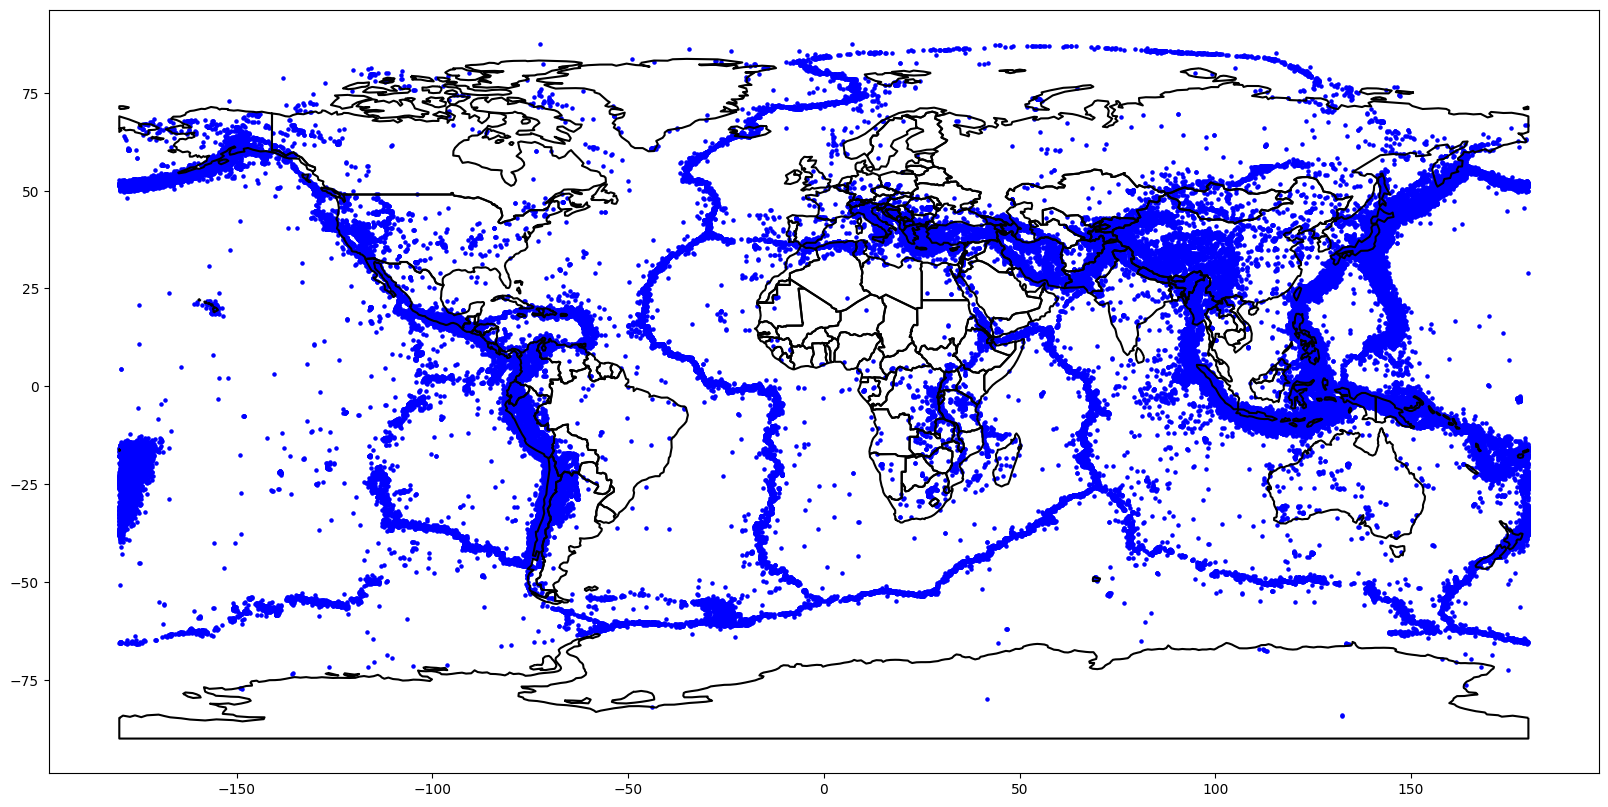

In [ ]:
gdf = gp.GeoDataFrame(dados, geometry=gp.points_from_xy(dados.longitude, dados.latitude))
world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))

fundo = world.boundary.plot(edgecolor='black', figsize=(20, 10))
gdf.plot(ax=fundo, marker='o', color='blue', markersize=5)

Para facilitar nossa analise, vamos criar uma coluna para guardar somente o ano que o dado foi registrado

In [ ]:
dados["ano"] = dados["time"].str.extract('(\d{4})').astype(int)

Por fim, vamos listar a origem dos tremores de terra registrados e a quantidade deles

In [ ]:
dados['type'].value_counts()

earthquake           282427
nuclear explosion       614
volcanic eruption        63
explosion                16
mine collapse             6
rock burst                3
other event               2
quarry blast              1
Name: type, dtype: int64

Dentre os itens, vamos escolher os dados de terremotos e de explosões nucleares (possívelmente se referem a testes de armas nucleares) para fazer uma pequena exploração neles.

##Terremotos

###Movimentação das placas tectonicas

A litosfera é a camada mais rígida da terra e divide-se em partes menores chamadas placas tectônicas. Essas placas tectônicas se movimentam lentamente, gerando um processo contínuo de esforço e deformação nas grandes massas da rocha. Quando esse esforço supera o limite de resistência da rocha, faz com que ela se rompa liberando parte da energia acumulada que é liberada sob forma de ondas elásticas, chamadas de ondas sísmicas. Essas ondas podem se espalhar em todas as direções, fazendo a terra vibrar intensamente, ocasionando os terremotos.


Com base nisso, vamos separar da nossa base de dados aqueles que tenham como origem terremotos e visualizá-los no mapa mundi.

<Axes: >

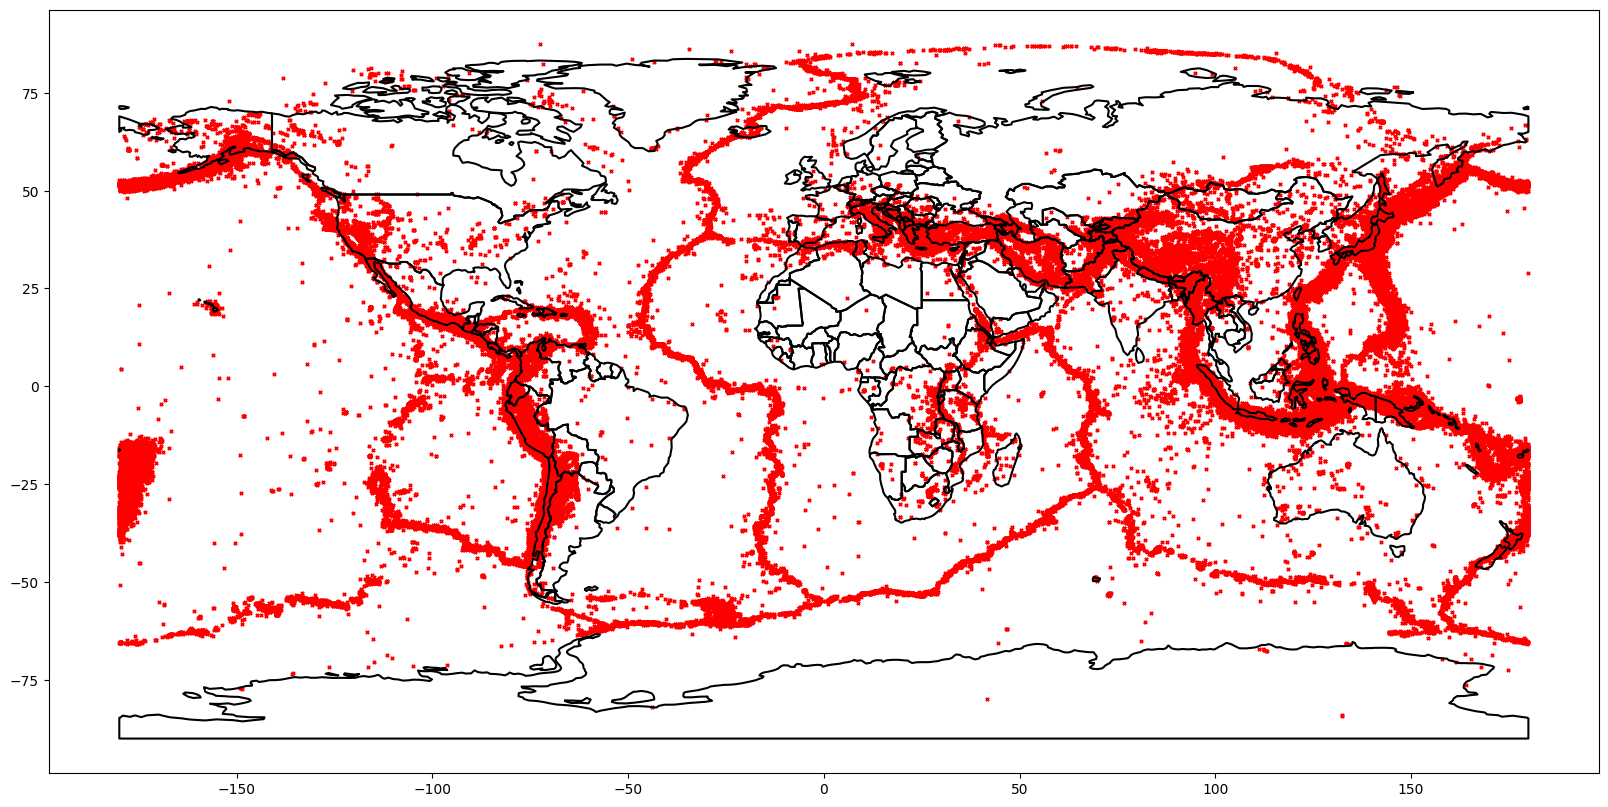

In [ ]:
terremotos = dados.loc[dados['type']=='earthquake']
gdf = gp.GeoDataFrame(terremotos, geometry=gp.points_from_xy(terremotos.longitude, terremotos.latitude))
world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))

fundo = world.boundary.plot(edgecolor='black', figsize=(20, 10))
gdf.plot(ax=fundo, marker='x', color='red', markersize=5)

E logo abaixo, temos o mapa das principais placas tectonicas terrestres

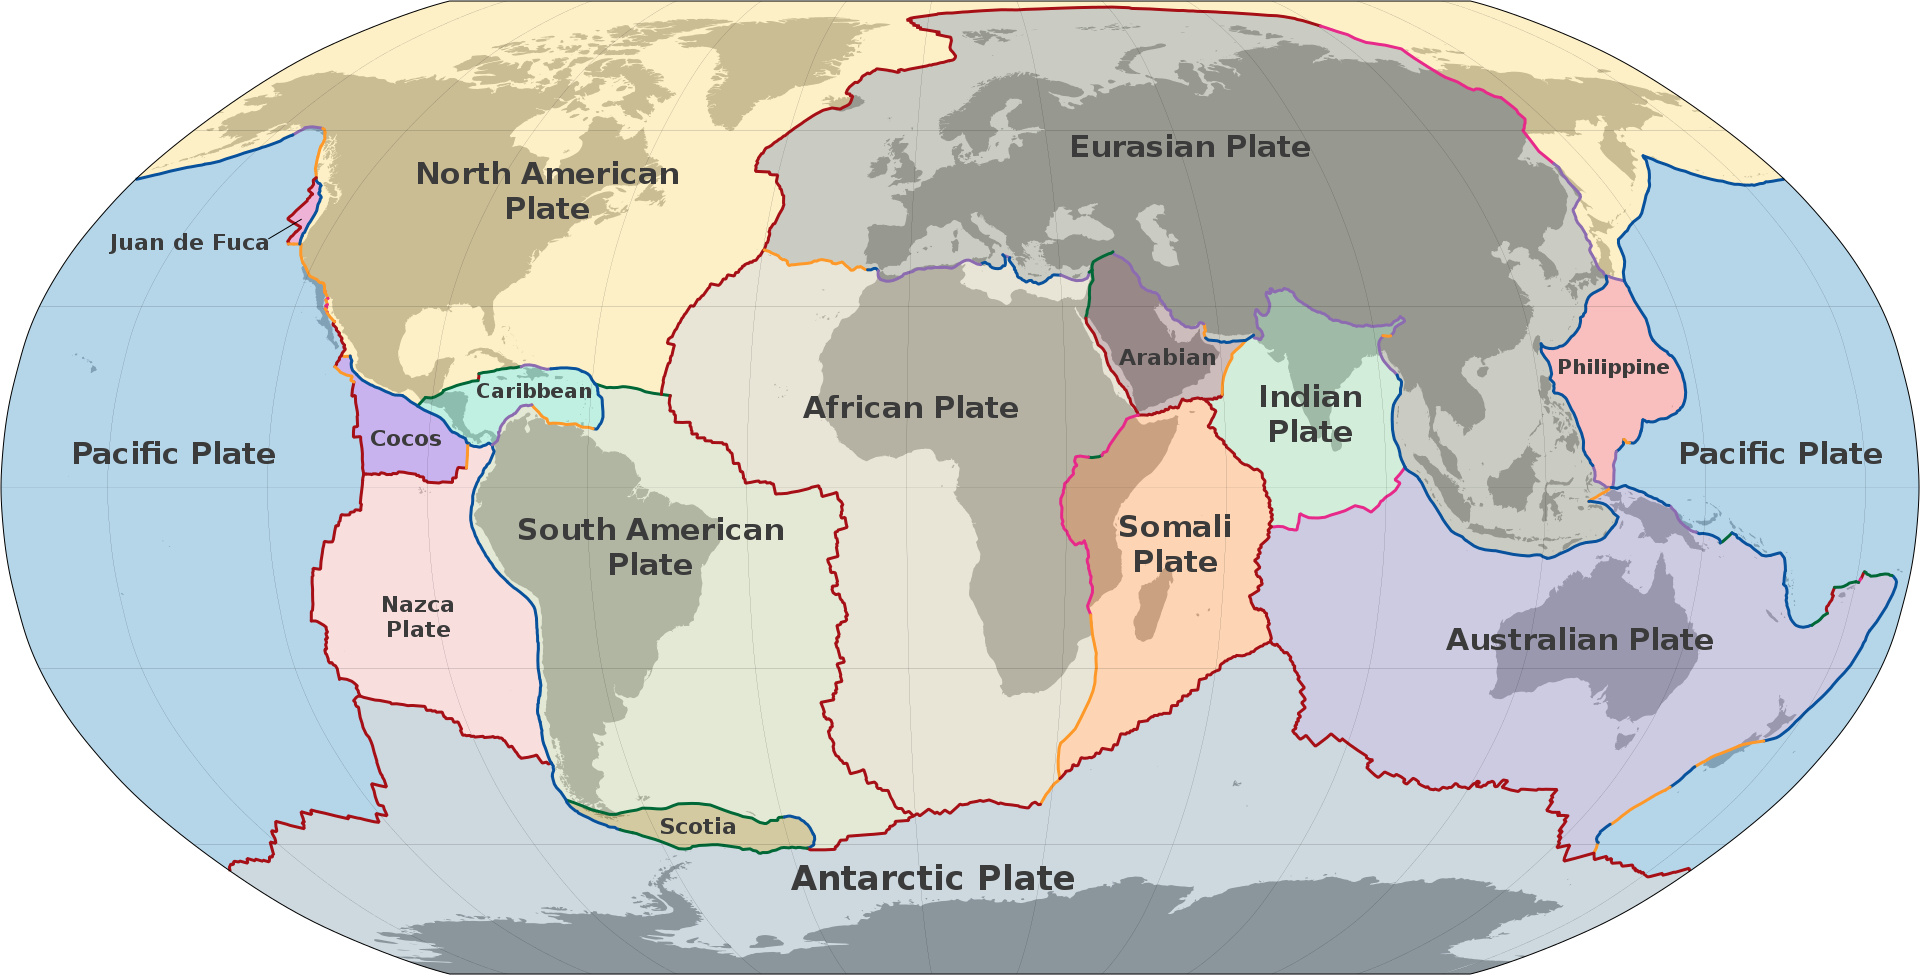

Comparando-se os dois mapas acimas, podemos perceber que a maior parte dos terremotos ocorrem justamente nas áreas de encontro com de placas tectonicas. 

Mas há algo notável no primeiro mapa e que será destacado na imagem a seguir

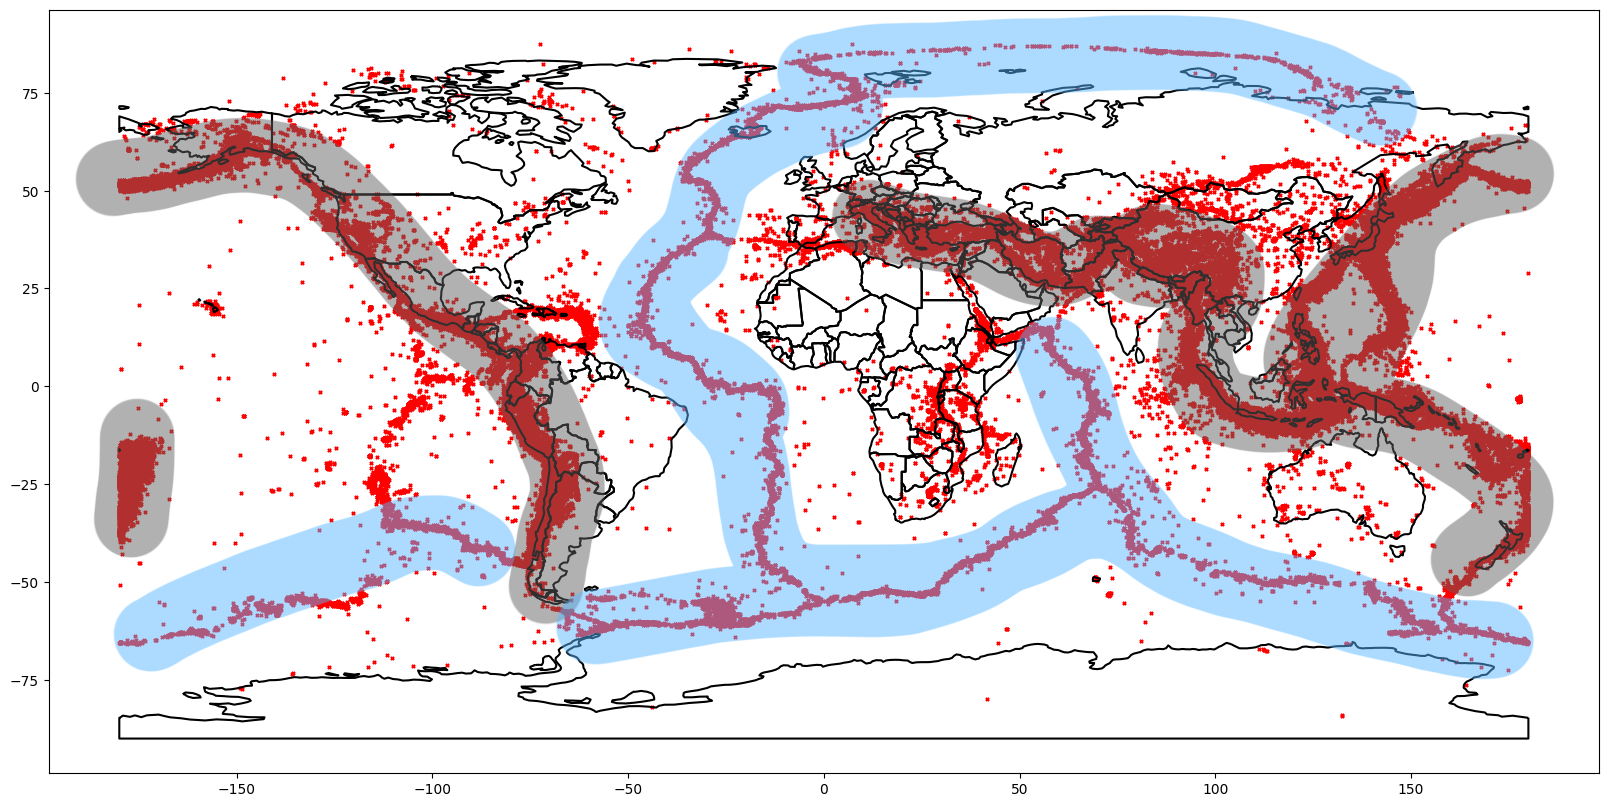

Percebe-se que há um maior número de terremotos (maior quantidade de pontos vermelhos) nas áreas destacadas em cinza do que nas áreas destacadas em azul.

Uma possível explicação seria que algumas placas estejam se aproximando de outras e se afastando de outras ao longo do tempo, como é o caso das placas 
dos continentes americanos, que podem estar se afastando das placas da Europa e da Africa e se aproximando das placas do oceano Pacífico, e as placas africanas, arábicas, indiana e austráriana estejam se aproximando da placa eurásiana.

E isso pode ser visualizado nos primeiros segundos do vídeo abaixo, feito pela Nasa sobre uma das possíveis movimentações das placas tectonicas até a formação de um novo supercontinente, nos próximos 200 milhões de anos.

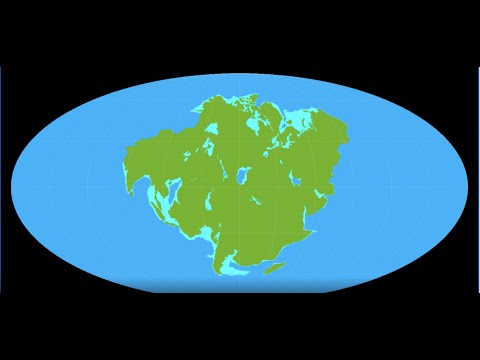

In [ ]:
from IPython.display import YouTubeVideo

video_id = 'F18LS8a5RuY'
YouTubeVideo(video_id)

###Analise dos top 5 terremotos mais fortes encontrados na base de dados

A nossa base de dados contem a coluna 'mag' que se refere a medida de intensidade do tremor de terra em escala richter.

Esse valor é uma medida logaritmica e é obtida após uma análise de dados coletados por um sismografo, aparelho que possui uma sensibilidade para registrar esses tremores.

A escala possui valores começando pelo 0 e não possui um limite superior, embora os maiores valores registrados até hoje encontram-se na faixa entre 9 e 10.

A tabela abaixo mostra a classificação da magnitude, os efeitos dos tremores e a frequencia deles por ano.

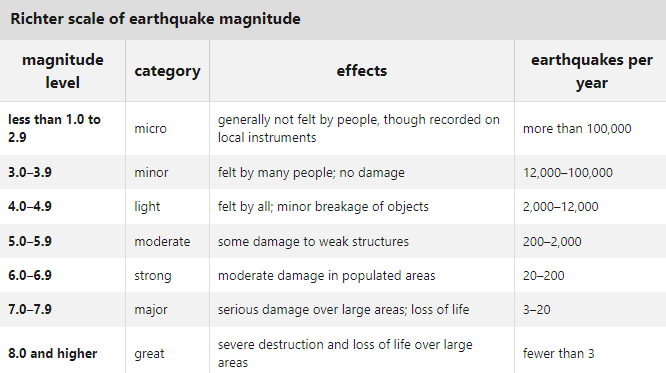

Com base nisso, vamos plotar um gráfico que mostra os 10 maiores valores de magnitude presentes em nossa base de dados, acompanhados de seus respectivos anos.

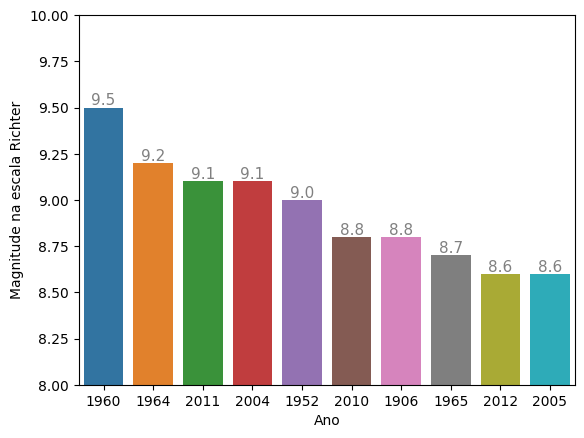

In [ ]:
maiores = terremotos.nlargest(10, 'mag')

# Criando o gráfico de barras
ax = sns.barplot(x='ano', y='mag', data=maiores, order=maiores.sort_values(by='mag', ascending=False).ano)
ax.set(ylabel="Magnitude na escala Richter")
ax.set(xlabel="Ano")
ax.set_ylim(8, 10)

# Adicionando legenda
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='gray', xytext=(0, 5),
                textcoords='offset points')

Agora vamos visualizar no mapa onde ocorreu os 5 maiores valores registrados e em seguida, um breve resumo do que se tem noticiado desses terremotos

In [ ]:
import folium
from branca.colormap import LinearColormap

maiores = terremotos.nlargest(5, 'mag')
m = folium.Map(location=[0, 0], zoom_start=2, height=800)
colormap = LinearColormap(colors=['red', 'orange', 'yellow', 'green', 'blue', 'purple'], vmin=maiores['mag'].min(), vmax=maiores['mag'].max())

for index, row in maiores.iterrows():
    folium.CircleMarker(location=[row['latitude'], row['longitude']], radius=row['mag']*3, fill=True, color=colormap(row['mag']), 
                        tooltip={'Magnitude':row['mag'],'Ano':row['ano'], 'Descrição':row['place']}).add_to(m)

colormap.caption = 'Intensidade'
m.add_child(colormap)

display(m)

####1 - Sismo de Valdivia de 1960
Data: 22 de maio de 1960

Local: Chile

Magnitude: 9.5 na escala Richter

Vitimas: mais de 1,6 mil vítimas fatais, 3 mil feridos e 2 milhões desabrigados.

Efeitos colaterais: Tsunamis com ondas de até 25m em diversos locais banhados pelo Oceano Pacífico, como no Havaí, Japão, Filipinas e costa oeste dos EUA.

Mais informações em: https://www.bbc.com/portuguese/geral-52773245

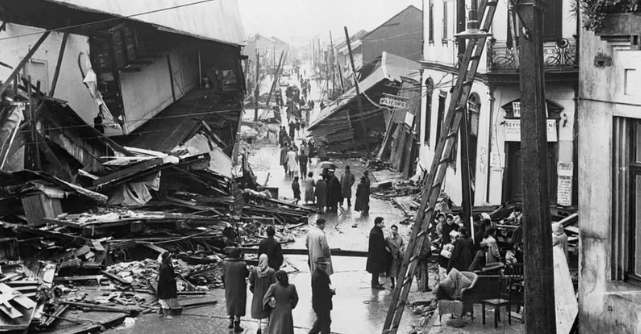

####2 - Terremoto de 1964 no Alaska
Data: 27 de março de 1964

Local: Alaska, EUA

Magnitude: 9.2 na escala Richter

Vitimas Fatais: Aproximadamente 130

Efeitos colaterais: Deslizamentos de terra

Mais informações em: https://ready.alaska.gov/_64Quake/History

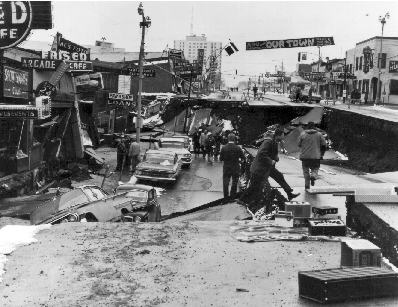

####3 - Sismo e Tsunâmi de Sendai
Data: 11 de março de 2011

Local: Costa Oeste do Japão

Magnitude: 9.1 na escala Richter

Vitimas: Mais de 19000 mortos e mais de 2000 desaparecidos

Efeitos colaterais: Tsunami, acidente nuclear na Usina de Fukushima, levando a um acidente nuclear.

Mais informações em: https://www.bbc.com/portuguese/internacional-55943220

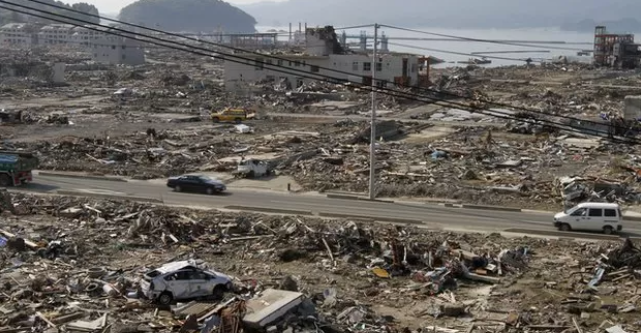

####4 - Sismo e tsunâmi do Oceano Índico de 2004
Data: 26 de dezembro de 2004

Local: Oceano Indico, costa da Indonesia

Magnitude: 9.1 na escala Richter

Vitimas Fatais: mais de 220 mil

Efeitos colaterais: Tsunami que atingiu principalmente a Indonesia e o Sri Lanka

Mais informações em: https://www.bbc.com/portuguese/internacional-55926800

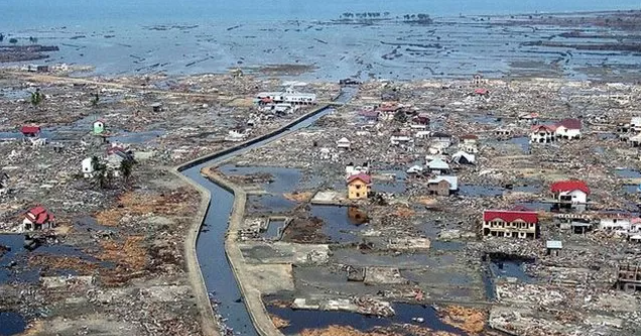

####5 - Terremoto de Severo-Kurilsk - 1952
Data: 5 de novembro de 1952

Local: Península de Camecháteca, Rússia

Magnitude: 9.0

Vitimas Fatais: Entre 10 mil a 15 mil

Efeitos colaterais: Tsunamis que causaram danos principalmente nas ilhas do Havaí

Mais informações em: https://www.wsspc.org/resources-reports/tsunami-center/significant-tsunami-events/1952-kamchatka-tsunami/

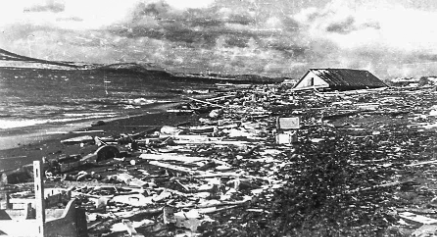

Algo notável nesses 5 casos é o fato deles terem ocorridos em áreas banhadas pelo Oceano Pacífico ou em áreas relativamente próximas a ele. Essa região, conhecida como Círculo de Fogo do Pacífico, concentra diversas placas tectônicas em constante movimento, resultando em atividades vulcânicas, terremotos e tsunamis. Entre os países afetados pelo Círculo de Fogo estão Japão, Indonésia, Filipinas, Equador, Chile e Estados Unidos.

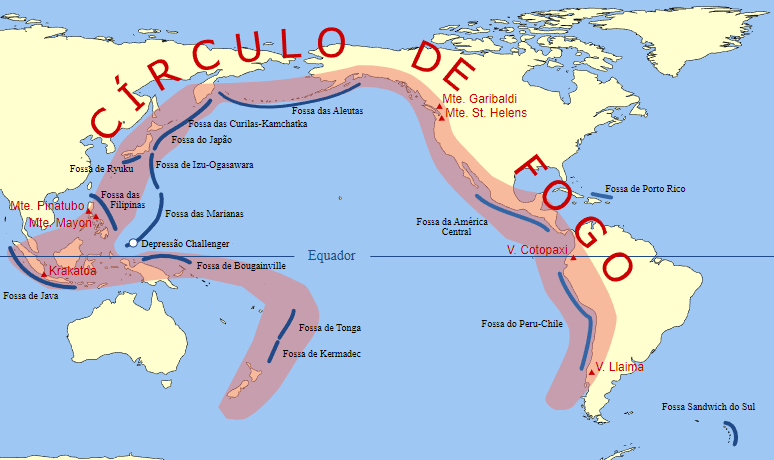

##Teste Nuclear

Os testes nucleares são uma série de testes realizados por países com armas nucleares para avaliar a tecnologia dessas armas. Tradicionalmente, esses testes foram realizados em áreas remotas e inabitadas, a fim de minimizar o impacto ambiental. No entanto, devido ao poder das armas nucleares, os testes foram capazes de gerar tremores de terra, resultando em terremotos sentidos a quilômetros de distância.


Vamos analisar em um gráfico a distribuição dos testes nucleares registrados em nossa base de dados ao longo dos anos.

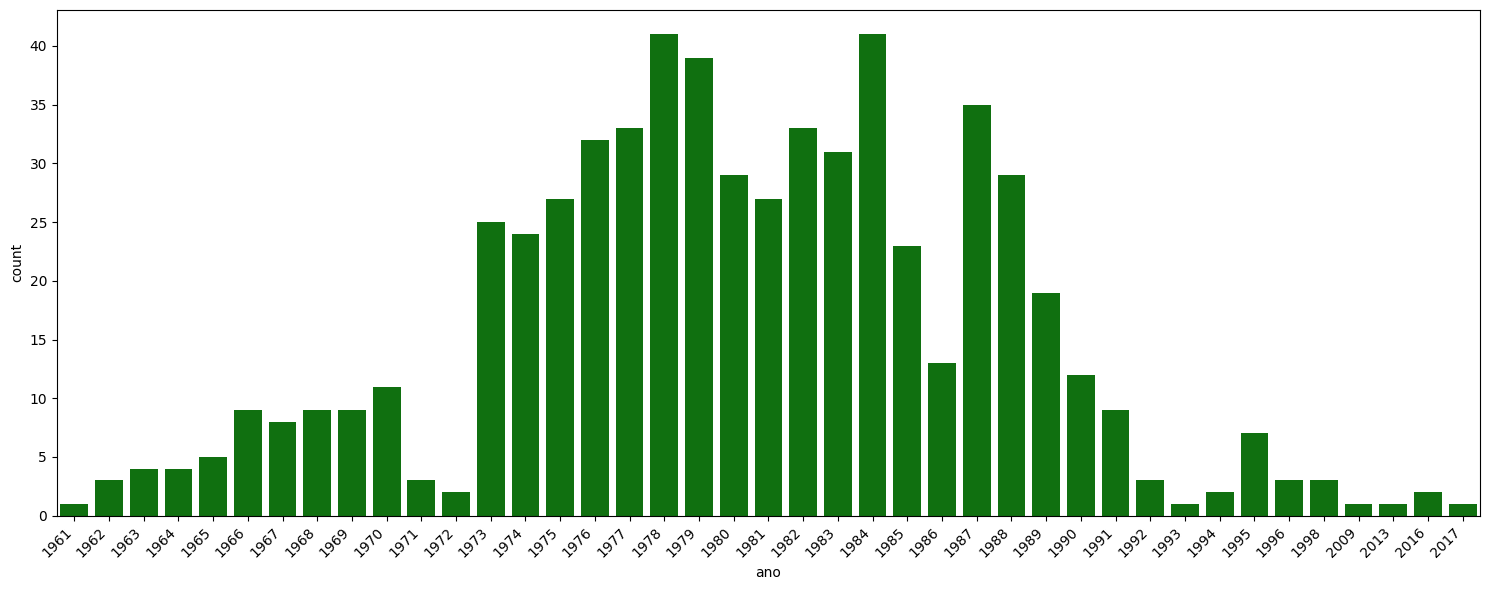

In [ ]:
import seaborn as sns

nuclear = dados.loc[dados['type']=='nuclear explosion']
fig, ax = plt.subplots(figsize=(15, 6))
sns.countplot(x="ano", data=nuclear, ax=ax, color='green')

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

Podemos observar que há um número significativo de testes nucleares nas décadas de 1970 e 1980. Essa época ficou conhecida como a Guerra Fria, um período de tensão política e militar entre as superpotências ocidental e oriental, com disputas pela hegemonia global. Durante esse período, as potências nucleares realizaram diversos testes para aprimorar suas tecnologias e demonstrar sua capacidade militar, contribuindo para o aumento da corrida armamentista e o temor de uma guerra nuclear.


Agora, iremos utilizar um mapa-mundi para visualizar geograficamente os locais onde os tremores decorrentes dos testes nucleares registrados em nossa base de dados ocorreram.

<Axes: >

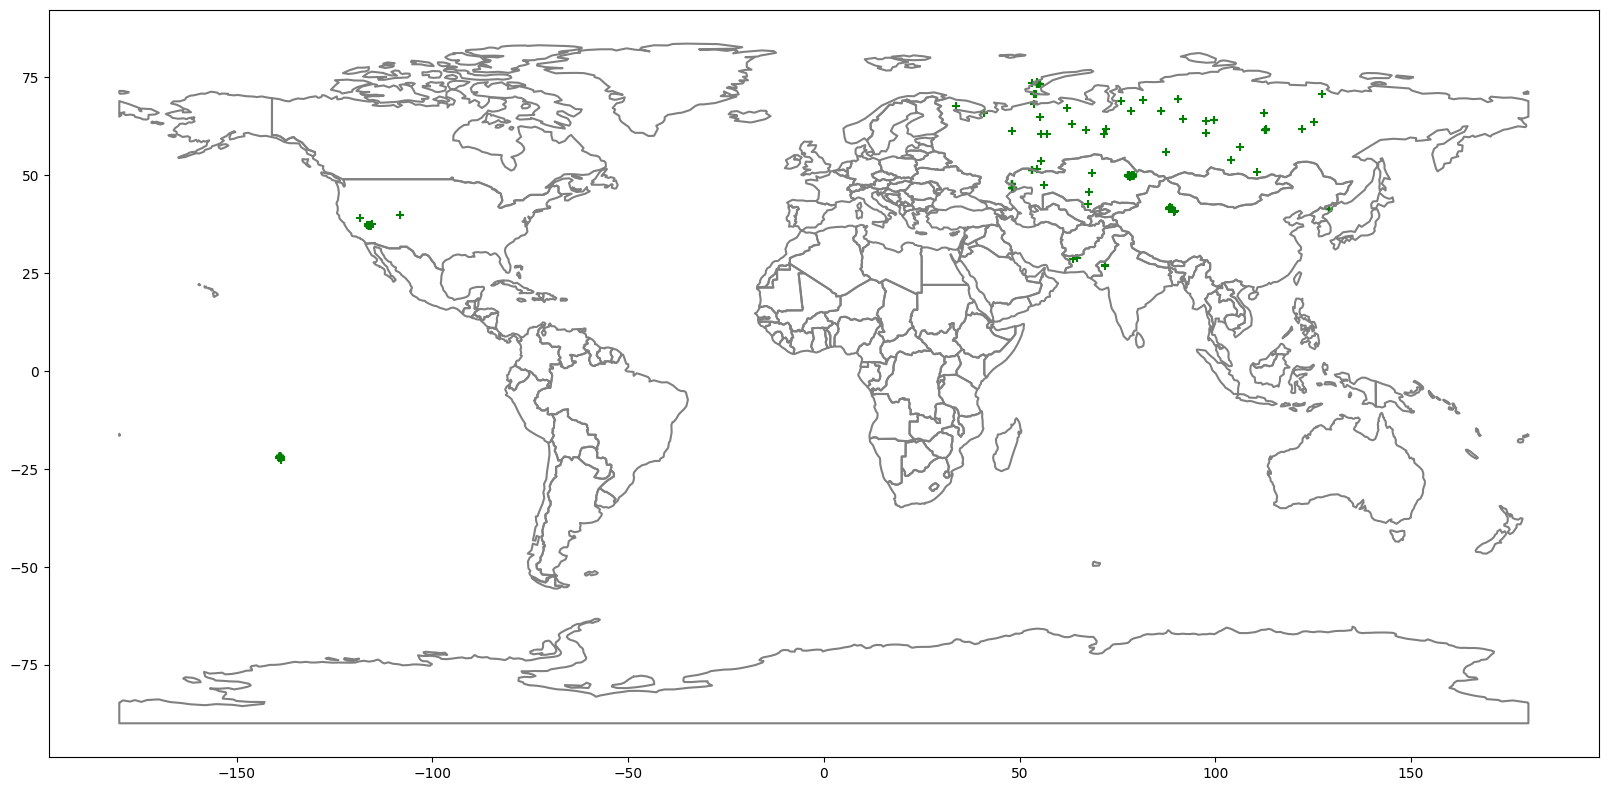

In [ ]:
gdf = gp.GeoDataFrame(nuclear, geometry=gp.points_from_xy(nuclear.longitude, nuclear.latitude))
world = gp.read_file(gp.datasets.get_path('naturalearth_lowres'))

fundo = world.boundary.plot(edgecolor='gray', figsize=(20, 10))
gdf.plot(ax=fundo, marker='+', color='green', markersize=30)

###Testes Nucleares durante a Guerra Fria

Agora vamos utilizar um mapa interativo para explorar em mais detalhes os locais onde ocorreram os testes nucleares durante o período anterior ao fim da Guerra Fria, que ocorreu em 1991. Essa ferramenta nos permitirá visualizar de forma mais precisa e dinâmica as informações sobre esses testes e suas localizações geográficas assim como da intensidade medida do tremor que isso causou.

In [ ]:
anteriores = nuclear.loc[dados['ano']<=1991]
m = folium.Map(location=[0, 0], zoom_start=2, height=800)
colormap = LinearColormap(colors=['red', 'orange', 'yellow', 'green', 'blue', 'purple'], vmin=anteriores['mag'].min(), vmax=anteriores['mag'].max())

for index, row in anteriores.iterrows():
    folium.CircleMarker(location=[row['latitude'], row['longitude']], radius=row['mag']*3, fill=True, color=colormap(row['mag']), 
                        tooltip={'Magnitude':row['mag'],'Ano':row['ano'], 'Descrição':row['place']}).add_to(m)

colormap.caption = 'Intensidade'
m.add_child(colormap)

display(m)

Após uma análise preliminar dos locais de testes nucleares, identificamos pelo menos três áreas que merecem destaque devido ao grande número de pontos próximos entre si. Isso pode indicar que essas regiões foram alvos de intensa atividade nuclear.

Arquipélago de Tuamotu - Sul do Oceano Pacífico

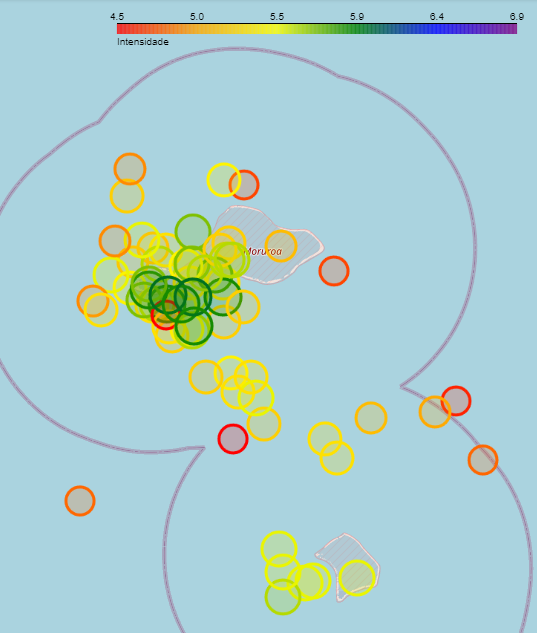

O arquipélago de Tuamotu foi palco de inúmeros testes nucleares realizados pela França entre os anos de 1966 e 1996. Mesmo após o fim desses testes, a radiação causada por esses eventos ainda gera consequências negativas nos dias atuais, afetando a saúde dos habitantes locais e o meio ambiente da região.

Mais informações em: https://www.theguardian.com/world/2013/jul/03/french-nuclear-tests-polynesia-declassified

Região ao norte de Las Vegas - Nevada - EUA

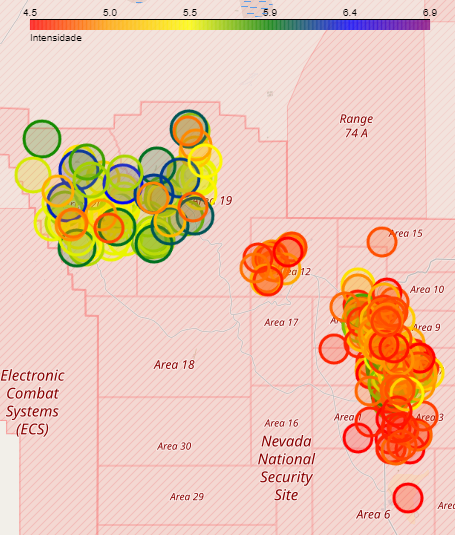

O local conhecido como Nevada Test Site foi utilizado para testes nucleares realizados pelos Estados Unidos durante a Guerra Fria, localizado no deserto de Nevada. Entre os anos de 1951 e 1992, foram realizados mais de 900 testes nucleares no local. Atualmente, o local foi renomeado para Nevada National Security Site (NNSS) e é usado para programas de defesa, pesquisa industrial e outras atividades, como testes e treinamentos de resposta a emergências nucleares e radiológicas.

Mais informações em: https://ahf.nuclearmuseum.org/ahf/location/nevada-test-site/

Norte do Cazaquistão

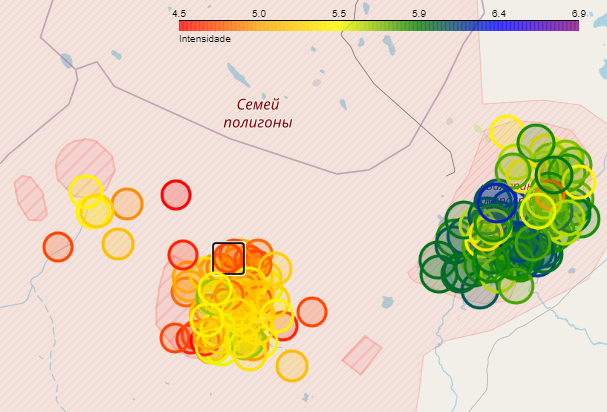

O campo de testes de Semipalatinsk, localizado no Cazaquistão, foi usado pela União Soviética para realizar mais de 450 testes nucleares entre 1949 e 1989. Os testes tiveram graves consequências para a saúde da população local e para o meio ambiente, resultando em aumento de doenças como câncer e malformações congênitas.

Mais informações em: https://www.bbc.com/portuguese/internacional-39064460

###Testes nucleares atualmente

Com o fim da Guerra Fria, a quantidade de testes de armas nucleares diminuiu significativamente em relação às décadas anteriores, como pode ser percebido no gráfico apresentado anteriormente. No entanto, ainda há registros de testes nucleares em alguns lugares do mundo que podem gerar tremores de terra. Para visualizar esses locais, podemos usar um mapa que mostra as áreas onde foram relatados terremotos que podem ter sido causados por testes nucleares recentes.

In [ ]:
recente = nuclear.loc[dados['ano']>1991]
m = folium.Map(location=[0, 0], zoom_start=2, height=800)
colormap = LinearColormap(colors=['red', 'orange', 'yellow', 'green', 'blue', 'purple'], vmin=recente['mag'].min(), vmax=recente['mag'].max())

for index, row in recente.iterrows():
    folium.CircleMarker(location=[row['latitude'], row['longitude']], radius=row['mag']*3, fill=True, color=colormap(row['mag']), 
                        tooltip={'Magnitude':row['mag'],'Ano':row['ano'], 'Descrição':row['place']}).add_to(m)

colormap.caption = 'Intensidade'
m.add_child(colormap)

display(m)

Uma breve análise dos dados apresentados acima nos permite verificar que ainda foram realizados testes nucleares nos locais citados anteriormente, como na Polinésia Francesa, em Nevada e ao noroeste da China. É importante destacar que houve registros de testes no território da Índia e do Paquistão, o que pode sugerir que esses países possuem ou estavam desenvolvendo armas nucleares. No entanto, é importante ressaltar que esses dados foram registrados na década de 1990 e desde então não houve mais registros, o que também não significa que não se tenha mais países desenvolvendo ou testando tais armas.

Um exemplo disso é a Coreia do Norte, que pelo menos desde 2009 vem realizando testes nucleares subterraneos e que foram detectados tremores de terra.

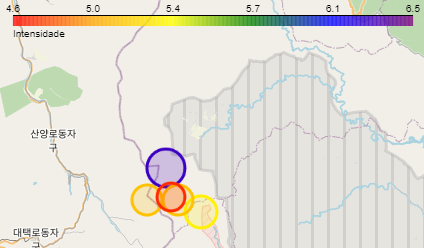